In [42]:
# ACTIONS
X_COORD_UP         = 0
Y_COORD_UP         = 1
SCALE_UP           = 2
ASPECT_RATIO_UP    = 3
X_COORD_DOWN       = 4
Y_COORD_DOWN       = 5
SCALE_DOWN         = 6
ASPECT_RATIO_DOWN  = 7
PLACE_LANDMARK     = 8
SKIP_REGION        = 9


DIMENSION = 224
STEP_FACTOR = 0.2
MAX_ASPECT_RATIO = 6.00
MIN_ASPECT_RATIO = 0.15
MIN_BOX_SIDE     = 10

class ObjLocaliser:
        
    def __init__(self, image, boundingBoxes):
        
        #Loading image using PIL librarry to resize it to standard dimention which is acceptable by the network
        #PILimg = Image.fromarray(image)
        PILimg = image
        #Resizing the image to be compatible to the network
        resized_img = PILimg.resize((DIMENSION,DIMENSION))
        #Image is stored as np array
        self.image_playground = np.array(resized_img)
        
        #Computing the scale of resize to recompute the position of bounding boxes
        self.x_scale = 224./im2.size[0]
        self.y_scale = 224./im2.size[1]
        
        #Multiplying xmin and xmax of boxes by x_scale and ymax and ymin by y_scale
        #self.xmin =
        #self.xmax =
        #self.ymin =
        #self.ymax =
        
        #Initializing sliding window from top left corner of the image
        #[x_top_left_corner, y_top_left_corner, x_down_right_corner, y_down_right_corner]
        self.agent_window = np.array([0,0,100,50])
        
        
        
        
    def wrapping(self):
        
        #Pick selected window from image
        im2 = self.image_playground[self.ymin:self.ymax,self.xmin:self.xmax]
        #Resizing the agent window to be compatible for network input
        resized = Image.fromarray(im2).resize((DIMENSION,DIMENSION))
        return resized
    
    
    def taking_actions(self,action):

        if action == X_COORD_UP:           
            self.xCoordUp()
        elif action == Y_COORD_UP:         
            self.yCoordUp()
        elif action == SCALE_UP:           
            self.scaleUp()
        elif action == ASPECT_RATIO_UP:    
            self.aspectRatioUp()
        elif action == X_COORD_DOWN:       
            self.xCoordDown()
        elif action == Y_COORD_DOWN:       
            self.yCoordDown()
        elif action == SCALE_DOWN:         
            self.scaleDown()
        elif action == ASPECT_RATIO_DOWN:  
            self.aspectRatioDown()
        #elif action == PLACE_LANDMARK:     self.placeLandmark()
        #if NUM_ACTIONS == 10 and action == SKIP_REGION:        self.skipRegion() 

        self.adjustAndClip()
        
        
        
    def adjustAndClip(self):
        
        #Cheching if x coordinate of the top left corner is out of bound    
        if self.agent_window[0] < 0:
            step = -self.agent_window[0]
            if self.agent_window[2] + step < self.image_playground.shape[0]:
                self.agent_window[0] += step
                self.agent_window[2] += step
            else:
                self.agent_window[0] = 0
                self.agent_window[2] = self.image_playground.shape[0] - 1

        #Cheching if y coordinate of the top left corner is out of bound    
        if self.agent_window[1] < 0:
            step = -self.agent_window[1]
            if self.agent_window[3] + step < self.image_playground.shape[1]:
                self.agent_window[1] += step
                self.agent_window[3] += step
            else:
                self.agent_window[1] = 0
                self.agent_window[3] = self.image_playground.shape[1] - 1

        #Cheching if x coordinate of the bottom right corner is out of bound    
        if self.agent_window[2] >= self.image_playground.shape[0]:
            step = self.agent_window[2] - self.image_playground.shape[0]
            if self.agent_window[0] - step >= 0:
                self.agent_window[0] -= step
                self.agent_window[2] -= step
            else:
                self.agent_window[0] = 0
                self.agent_window[2] = self.image_playground.shape[0] - 1

        #Cheching if y coordinate of the bottom right corner is out of bound    
        if self.agent_window[3] >= self.image_playground.shape[1]:
            step = self.agent_window[3] - self.image_playground.shape[1]
            if self.agent_window[1] - step >= 0:
                self.agent_window[1] -= step
                self.agent_window[3] -= step
            else:
                self.agent_window[1] = 0
                self.agent_window[3] = self.image_playground.shape[1] - 1

            

    def xCoordUp(self):
        
        boxW = self.agent_window[2] - self.agent_window[0]
        step = STEP_FACTOR * boxW
        # This action preserves box width and height
        if self.agent_window[0] + step + boxW < self.image_playground.shape[0]:
            self.agent_window[0] += step
            self.agent_window[2] += step
        else:
            self.agent_window[0] = self.image_playground.shape[0] - boxW - 1
            self.agent_window[2] = self.image_playground.shape[0] - 1 
            
            

    def yCoordUp(self):
        
        boxH = self.agent_window[3] - self.agent_window[1]
        step = STEP_FACTOR * boxH
        # This action preserves box width and height
        if self.agent_window[1] + step + boxH < self.image_playground.shape[1]:
            self.agent_window[1] += step
            self.agent_window[3] += step
        else:
            self.agent_window[1] = self.image_playground.shape[1] - boxH - 1
            self.agent_window[3] = self.image_playground.shape[1] - 1
        
        
        
        
        
    def scaleUp(self):
        
        boxW = self.agent_window[2] - self.agent_window[0]
        boxH = self.agent_window[3] - self.agent_window[1]
        
        # This action preserves aspect ratio
        widthChange = STEP_FACTOR * boxW
        heightChange = STEP_FACTOR * boxH
        
        if boxW + widthChange < self.image_playground.shape[0]:
            if boxH + heightChange < self.image_playground.shape[1]:
                newDelta = STEP_FACTOR
            else:
                newDelta = self.image_playground.shape[1]/boxH - 1
        else:
            newDelta = self.image_playground.shape[0] / boxW - 1
            if boxH + newDelta * boxH >= self.image_playground.shape[1]:
                newDelta = self.image_playground.shape[1] / boxH - 1
        
        widthChange = newDelta * boxW / 2.0
        heightChange = newDelta * boxH / 2.0
        self.agent_window[0] -= widthChange
        self.agent_window[1] -= heightChange
        self.agent_window[2] += widthChange
        self.agent_window[3] += heightChange

        
        

    def aspectRatioUp(self):

        boxH = self.agent_window[3] - self.agent_window[1]
        boxW = self.agent_window[2] - self.agent_window[0]
        
        # This action preserves width
        heightChange = STEP_FACTOR * boxH
        
        if boxH + heightChange < self.image_playground.shape[1]:
            ar = (boxH + heightChange) / boxW
            if ar < MAX_ASPECT_RATIO:
                newDelta = STEP_FACTOR
            else:
                newDelta = 0.0
        else:
            newDelta = self.agent_window[1] / boxH - 1
            ar = (boxH + newDelta * boxH) / boxW
            if ar > MAX_ASPECT_RATIO:
                newDelta =  0.0
                
        heightChange = newDelta * boxH / 2.0
        self.agent_window[1] -= heightChange
        self.agent_window[3] += heightChange

        
        
    def xCoordDown(self):
        
        boxW = self.agent_window[2] - self.agent_window[0]
        step = STEP_FACTOR * boxW
        
        # This action preserves box width and height
        if self.agent_window[0] - step >= 0:
            self.agent_window[0] -= step
            self.agent_window[2] -= step
        else:
            self.agent_window[0] = 0
            self.agent_window[2] = boxW
        


    def yCoordDown(self):

        boxH = self.agent_window[3] - self.agent_window[1]
        
        step = STEP_FACTOR * boxH
        # This action preserves box width and height
        if self.agent_window[1] - step >= 0:
            self.agent_window[1] -= step
            self.agent_window[3] -= step
        else:
            self.agent_window[1] = 0
            self.agent_window[3] = boxH

            
            

    def scaleDown(self):
        
        boxH = self.agent_window[3] - self.agent_window[1]
        boxW = self.agent_window[2] - self.agent_window[0]
        
        # This action preserves aspect ratio
        widthChange = STEP_FACTOR * boxW
        heightChange = STEP_FACTOR * boxH
        
        if boxW - widthChange >= MIN_BOX_SIDE:
            if boxH - heightChange >= MIN_BOX_SIDE:
                newDelta = STEP_FACTOR
            else:
                newDelta = MIN_BOX_SIDE / boxH - 1
        else:
            newDelta = MIN_BOX_SIDE / boxW - 1
            if  boxH - newDelta *  boxH < MIN_BOX_SIDE:
                newDelta = MIN_BOX_SIDE /  boxH - 1
        widthChange = newDelta * boxW / 2.0
        heightChange = newDelta * boxH / 2.0
        self.agent_window[0] += widthChange
        self.agent_window[1] += heightChange
        self.agent_window[2] -= widthChange
        self.agent_window[3] -= heightChange

        
        
        
    def aspectRatioDown(self):

        boxW = self.agent_window[2] - self.agent_window[0]
        boxH = self.agent_window[3] - self.agent_window[1]

        # This action preserves height
        widthChange = STEP_FACTOR * boxW
        if boxW + widthChange < self.image_playground.shape[0]:
            ar = boxH / (boxW + widthChange)
            if ar >= MIN_ASPECT_RATIO:
                newDelta = STEP_FACTOR
            else:
                newDelta = 0.0
        else:
            newDelta = self.image_playground.shape[0] / boxW - 1
            ar = boxH / (boxW + newDelta * boxW)
            if ar < MIN_ASPECT_RATIO:
                newDelta =  0.0
        widthChange = newDelta * boxW / 2.0
        self.agent_window[0] -= widthChange
        self.agent_window[2] += widthChange
        
         
    def placeLandmark(self):
        self.landmarkIndex[ fingerprint(self.box) ] = self.box[:]
        self.stepsWithoutLandmark = 0
        return self.box

        
        
        
    def drawActions(self):
        
        im = np.array(Image.open('../VOC2012/JPEGImages/2010_000959.jpg'), dtype=np.uint8)

        # Create figure and axes
        fig,ax = plt.subplots(1)

        # Display the image
        ax.imshow(self.image_playground)

        # Create a Rectangle patch
        rect = patches.Rectangle((self.agent_window[0],self.agent_window[1]),self.agent_window[2],self.agent_window[3],linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        plt.show()

        

In [52]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
%matplotlib inline
import time


# ACTIONS
X_COORD_UP         = 0
Y_COORD_UP         = 1
SCALE_UP           = 2
ASPECT_RATIO_UP    = 3
X_COORD_DOWN       = 4
Y_COORD_DOWN       = 5
SCALE_DOWN         = 6
ASPECT_RATIO_DOWN  = 7
PLACE_LANDMARK     = 8
SKIP_REGION        = 9

im2 = (Image.open('../VOC2012/JPEGImages/2010_000959.jpg'))



action:1


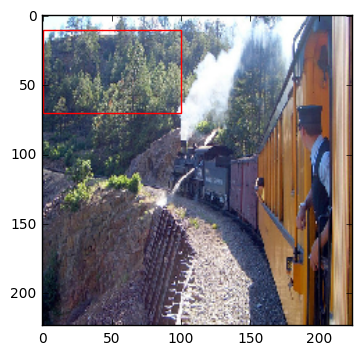

action:1


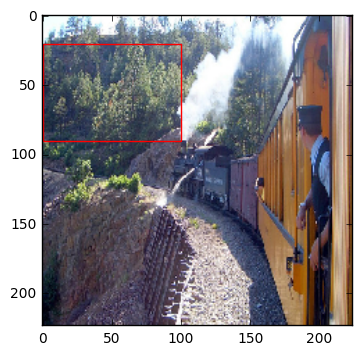

action:1


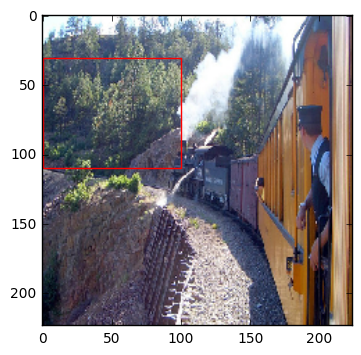

action:0


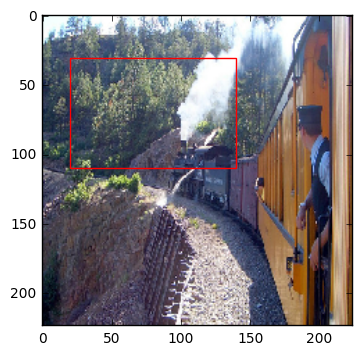

action:0


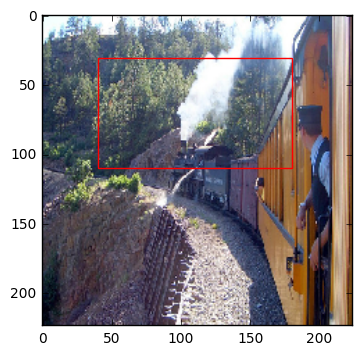

action:3


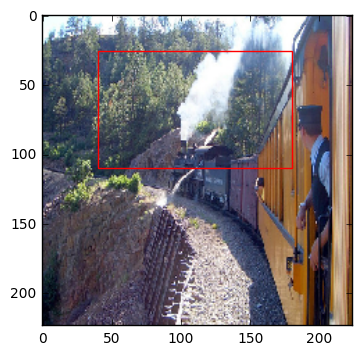

action:3


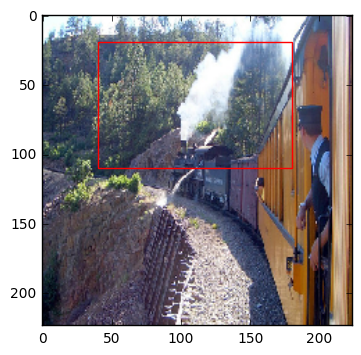

action:3


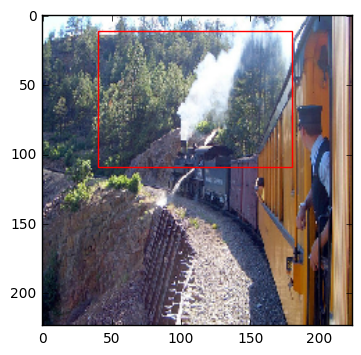

action:3


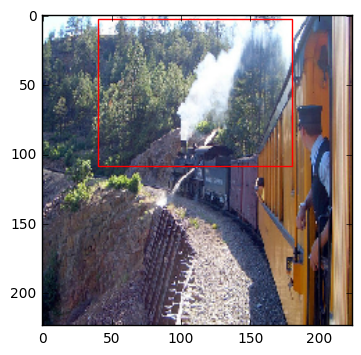

action:3


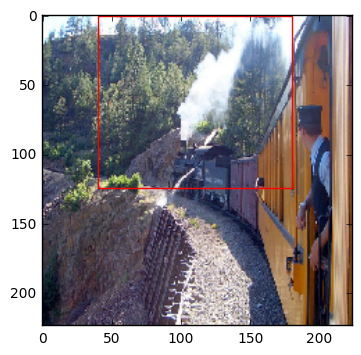

action:3


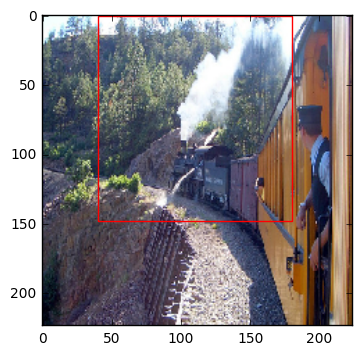

action:3


action:3


action:6


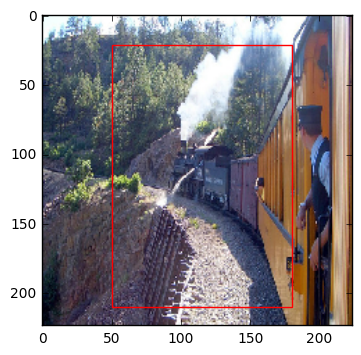

action:6


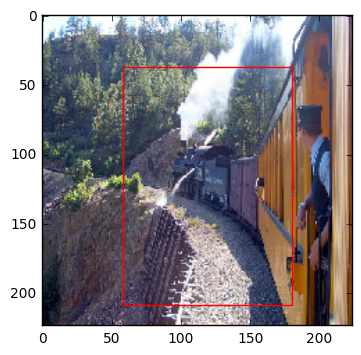

action:6


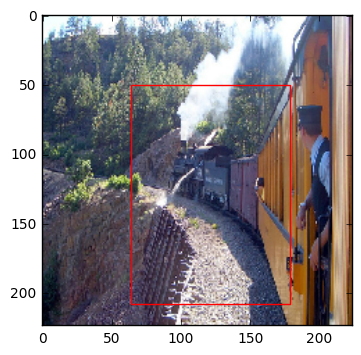

action:6


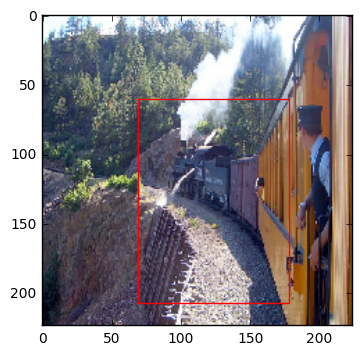

action:6


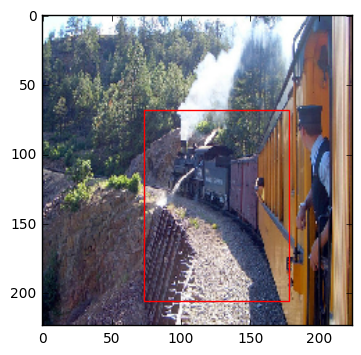

action:0


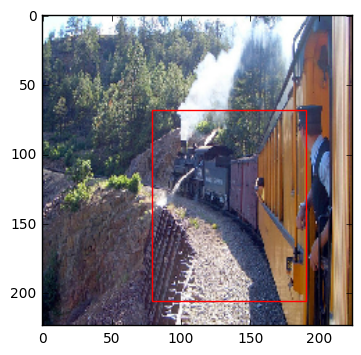

action:0


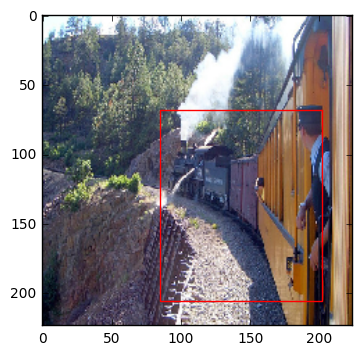

action:0


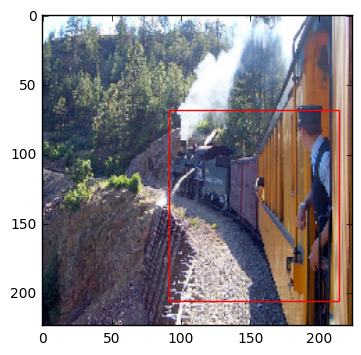

action:0


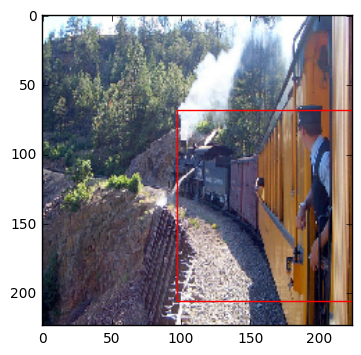

action:6


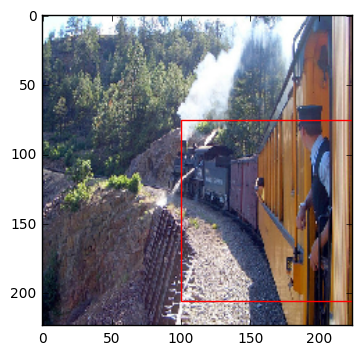

action:6


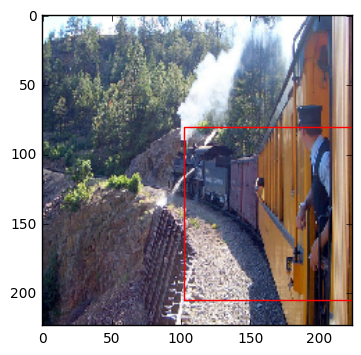

action:6


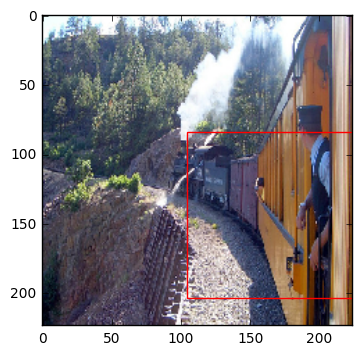

action:6


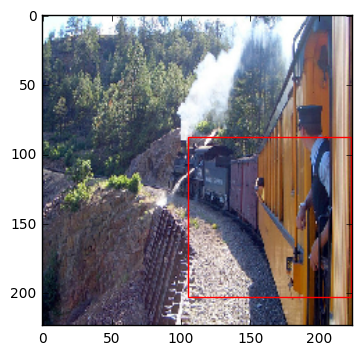

In [63]:
import random
actions = np.array(random.sample(range(0, 10),9))
agent = ObjLocaliser(im2,[])
for act in [1,1,1,0,0,3,3,3,3,3,3,3,3,6,6,6,6,6,0,0,0,0,6,6,6,6]:
    print("action:{0}".format(act))
    agent.taking_actions(act)
    agent.drawActions()
    time.sleep(1)
    